# Challenge

https://www.kaggle.com/c/acea-water-prediction/

Inspired by: https://www.kaggle.com/code/xueyingzhao009/time-series-analysis-acea-smart-water-analysis/notebook

# Set the Environment

In [509]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

#from colorama import Fore
#import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import  SARIMAX

import pmdarima as pm

import math

from datetime import datetime, date 

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "./data/" directory
# List all files under the data directory

import os
#for dirname, _, filenames in os.walk(r'C:\Users\A393350\Desklocalhost:8888/notebooks/Desktop/Kaggle/AceaSmartWaterAnalytics/notebookDada.ipynbtop\Kaggle\AceaSmartWaterAnalytics\data'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk('./data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data/Aquifer_Auser.csv
./data/Aquifer_Doganella.csv
./data/Aquifer_Luco.csv
./data/Aquifer_Petrignano.csv
./data/CI Alert Model-priority.csv
./data/datasets_description.ods
./data/Lake_Bilancino.csv
./data/River_Arno.csv
./data/Water_Spring_Amiata.csv
./data/Water_Spring_Lupa.csv
./data/Water_Spring_Madonna_di_Canneto.csv


In [324]:
%pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\ITMONDINOC\Miniconda3\python.exe -m pip install --upgrade pip' command.


# Load Data

We will focus on Aquifer Petrignano to start with. 

We will also try to forecast Depth to Groundwater as univariate time series.

In [8]:
df_raw = pd.read_csv(".\data/Aquifer_Petrignano.csv")

#df = df[["Date","Depth_to_Groundwater_P25"]]

df_raw.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


In [9]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5223 entries, 0 to 5222
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Date                                  5223 non-null   object 
 1   Rainfall_Bastia_Umbra                 4199 non-null   float64
 2   Depth_to_Groundwater_P24              5168 non-null   float64
 3   Depth_to_Groundwater_P25              5184 non-null   float64
 4   Temperature_Bastia_Umbra              4199 non-null   float64
 5   Temperature_Petrignano                4199 non-null   float64
 6   Volume_C10_Petrignano                 5025 non-null   float64
 7   Hydrometry_Fiume_Chiascio_Petrignano  4199 non-null   float64
dtypes: float64(7), object(1)
memory usage: 326.6+ KB


In [16]:
df_raw['Date'] = pd.to_datetime(df_raw['Date'], format = '%d/%m/%Y')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5223 entries, 0 to 5222
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Date                                  5223 non-null   datetime64[ns]
 1   Rainfall_Bastia_Umbra                 4199 non-null   float64       
 2   Depth_to_Groundwater_P24              5168 non-null   float64       
 3   Depth_to_Groundwater_P25              5184 non-null   float64       
 4   Temperature_Bastia_Umbra              4199 non-null   float64       
 5   Temperature_Petrignano                4199 non-null   float64       
 6   Volume_C10_Petrignano                 5025 non-null   float64       
 7   Hydrometry_Fiume_Chiascio_Petrignano  4199 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 326.6 KB


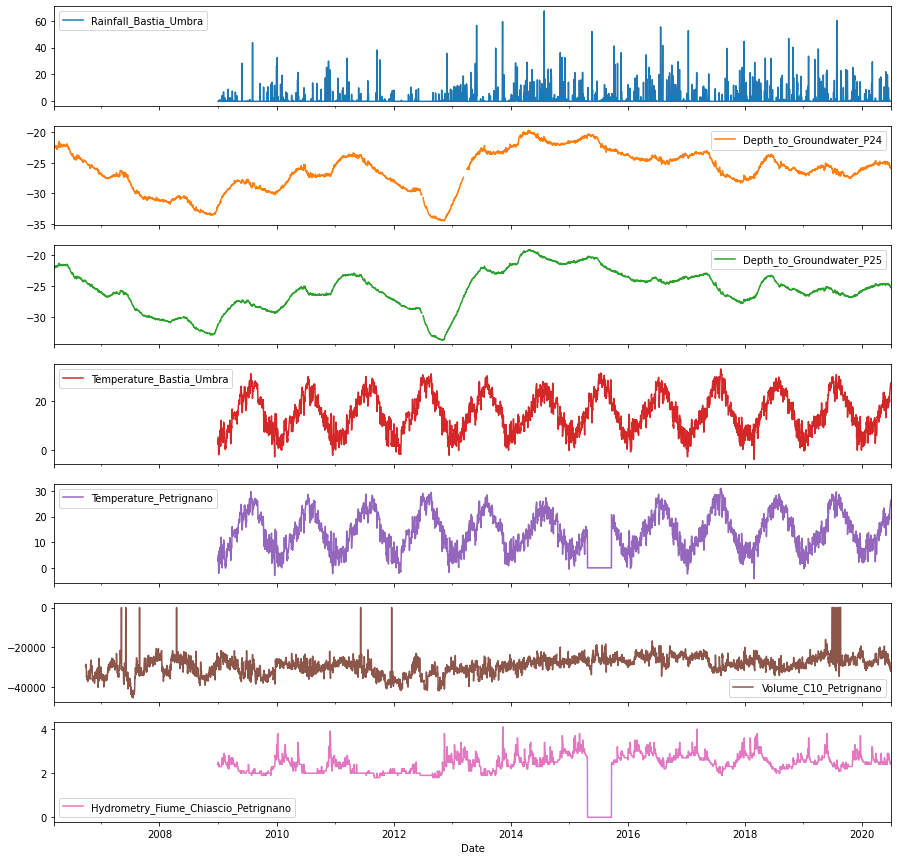

In [19]:
df_raw.set_index('Date').plot(subplots=True, figsize=(15, 15))

plt.show()

# Data Prep
- convert Date in datetime format
- select only relevant columns (Date + Depth to Groundwater)

In [75]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5223 entries, 0 to 5222
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Date                                  5223 non-null   datetime64[ns]
 1   Rainfall_Bastia_Umbra                 4199 non-null   float64       
 2   Depth_to_Groundwater_P24              5168 non-null   float64       
 3   Depth_to_Groundwater_P25              5184 non-null   float64       
 4   Temperature_Bastia_Umbra              4199 non-null   float64       
 5   Temperature_Petrignano                4199 non-null   float64       
 6   Volume_C10_Petrignano                 5025 non-null   float64       
 7   Hydrometry_Fiume_Chiascio_Petrignano  4199 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 326.6 KB


In [76]:
df = df_raw[['Date', 'Depth_to_Groundwater_P24', 'Depth_to_Groundwater_P25']].set_index('Date').asfreq('d')
#df['Date'] = pd.to_datetime(df.Date, format = '%d/%m/%Y')

df.head()

,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25
Date,,
2006-03-14,-22.48,-22.18
2006-03-15,-22.38,-22.14
2006-03-16,-22.25,-22.04
2006-03-17,-22.38,-22.04
2006-03-18,-22.60,-22.04


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5223 entries, 2006-03-14 to 2020-06-30
Freq: D
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Depth_to_Groundwater_P24  5168 non-null   float64
 1   Depth_to_Groundwater_P25  5184 non-null   float64
dtypes: float64(2)
memory usage: 122.4 KB


In [78]:
df.shape

(5223, 2)

## Data Visualization

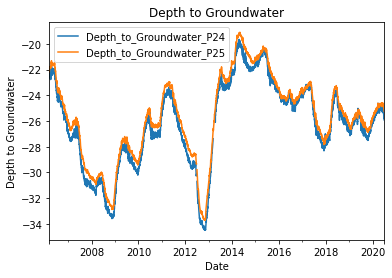

In [79]:
df.plot()

plt.title('Depth to Groundwater')
plt.ylabel('Depth to Groundwater')

plt.show()

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5223 entries, 2006-03-14 to 2020-06-30
Freq: D
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Depth_to_Groundwater_P24  5168 non-null   float64
 1   Depth_to_Groundwater_P25  5184 non-null   float64
dtypes: float64(2)
memory usage: 122.4 KB


In [83]:
df.isna().sum()

Depth_to_Groundwater_P24    55
Depth_to_Groundwater_P25    39
dtype: int64

In [84]:
df.shape[0]

5223

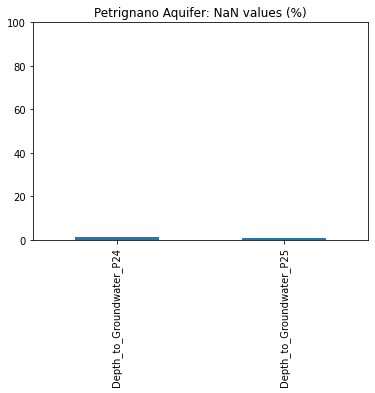

In [85]:
df.isna().sum().div(df.shape[0]).mul(100).plot(kind='bar')

plt.title('Petrignano Aquifer: NaN values (%)')
plt.ylim((0, 100))

plt.show()

We will use Depth_to_Groundwater_P25 as it contains less missing values

In [86]:
df.isna().sum().div(df.shape[0]).mul(100)

Depth_to_Groundwater_P24    1.053035
Depth_to_Groundwater_P25    0.746697
dtype: float64

## Interpolate missing values

In [87]:
df.head()

,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25
Date,,
2006-03-14,-22.48,-22.18
2006-03-15,-22.38,-22.14
2006-03-16,-22.25,-22.04
2006-03-17,-22.38,-22.04
2006-03-18,-22.60,-22.04


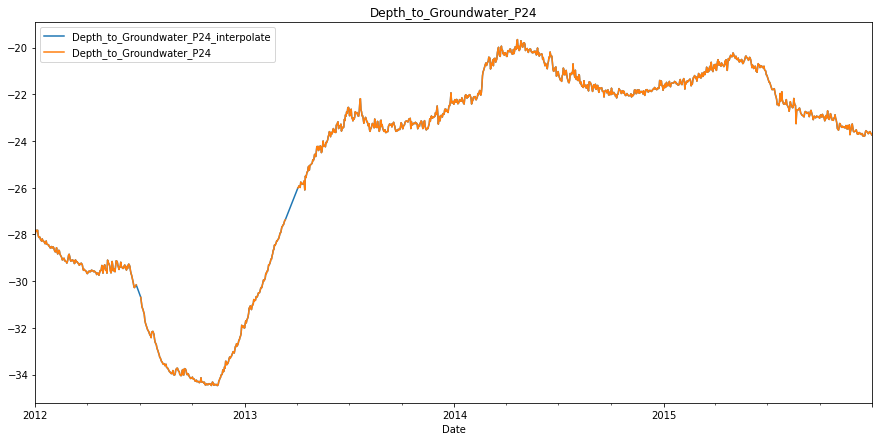

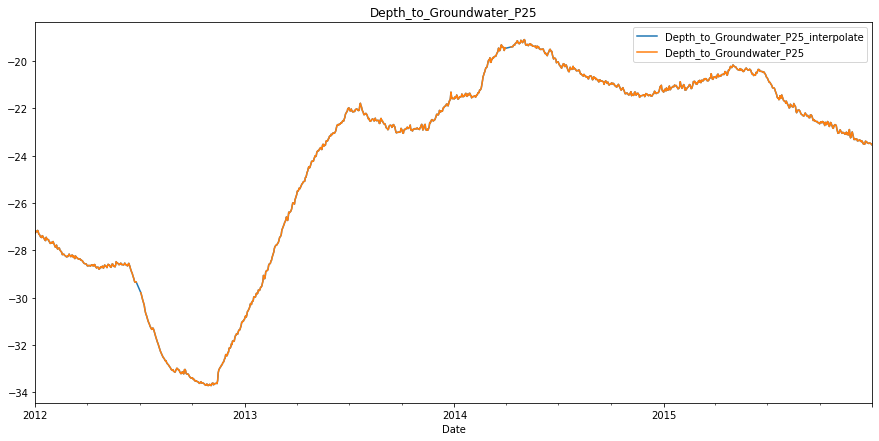

In [95]:
for col in df.columns:
    #print(col)
    new_col = col + '_interpolate'
    df_temp = df.loc['2012':'2015']
    df_temp[new_col] = df_temp[col].interpolate()
    
    df_temp[[new_col, col]].plot(figsize=(15, 7))
    plt.title(col)
    plt.show()

We will use Depth_to_Groundwater_P25 and interpolate with linear method

In [97]:
df.head()

,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25
Date,,
2006-03-14,-22.48,-22.18
2006-03-15,-22.38,-22.14
2006-03-16,-22.25,-22.04
2006-03-17,-22.38,-22.04
2006-03-18,-22.60,-22.04


In [514]:
df_model = df[['Depth_to_Groundwater_P25']].rename(columns={'Depth_to_Groundwater_P25':'Depth_to_Groundwater'}).interpolate()

df_model.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5223 entries, 2006-03-14 to 2020-06-30
Freq: D
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Depth_to_Groundwater  5223 non-null   float64
dtypes: float64(1)
memory usage: 210.6 KB


## Time  Series Decomposition

Analyse Trend and Seasonal Component of the time series

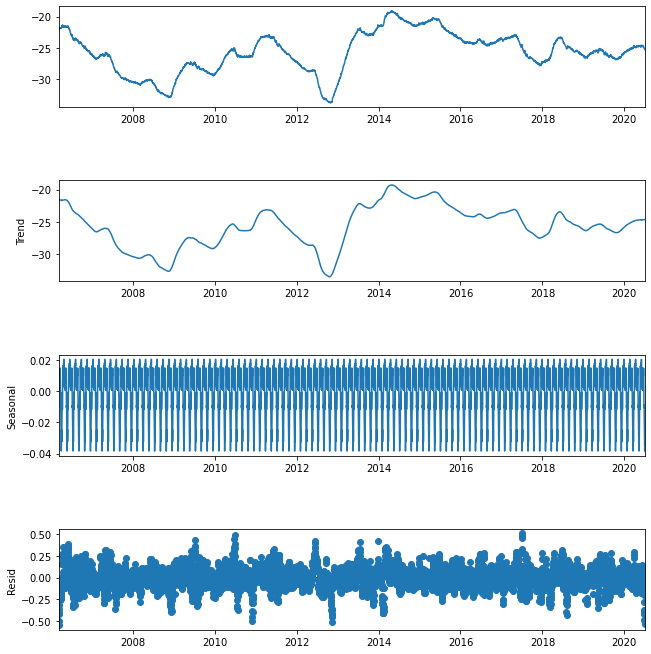

In [544]:
for col in df_model.columns:
    decomp_results = seasonal_decompose(df_model, period=52, model='additive', extrapolate_trend='freq')
    fig  = decomp_results.plot()
    fig.set_size_inches((10, 10))
    plt.show()

In [545]:
df_model_downsampled = df_model.resample('7D').mean()

df_model_downsampled.head()

,Depth_to_Groundwater
Date,
2006-03-14,-22.054286
2006-03-21,-21.847143
2006-03-28,-21.840000
2006-04-04,-21.744286
2006-04-11,-21.440000


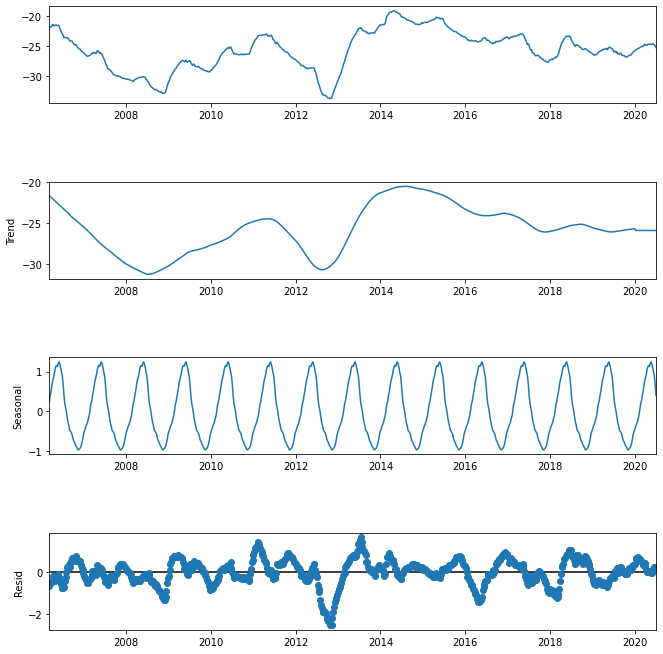

In [546]:
for col in df_model_downsampled.columns:
    decomp_results = seasonal_decompose(df_model_downsampled, period=52, model='additive', extrapolate_trend='freq')
    fig  = decomp_results.plot()
    fig.set_size_inches((10, 10))
    plt.show()

### Old

In [532]:
def plot_decomp(df_model):
    
    df_model_decomp = df_model.copy()
    
    for col in df_model_decomp.columns:
        decomp = seasonal_decompose(df_model_decomp, period=52, model='additive', extrapolate_trend='freq')
        df_model_decomp[f'{col}_trend'] = decomp.trend
        df_model_decomp[f'{col}_seasonal'] = decomp.seasonal
    
    df_model_decomp["Depth_to_Groundwater_trend"].plot(figsize=(10,5))
    plt.show()

    df_model_decomp["Depth_to_Groundwater_seasonal"].plot(figsize=(10,5))
    plt.show()
    
    return df_model_decomp

In [533]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5223 entries, 2006-03-14 to 2020-06-30
Freq: D
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Depth_to_Groundwater  5223 non-null   float64
dtypes: float64(1)
memory usage: 210.6 KB


In [534]:
df_model_downsampled = df_model.resample('7D').mean()

df_model_downsampled.head()

,Depth_to_Groundwater
Date,
2006-03-14,-22.054286
2006-03-21,-21.847143
2006-03-28,-21.840000
2006-04-04,-21.744286
2006-04-11,-21.440000


In [535]:
df_model_downsampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 747 entries, 2006-03-14 to 2020-06-30
Freq: 7D
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Depth_to_Groundwater  747 non-null    float64
dtypes: float64(1)
memory usage: 11.7 KB


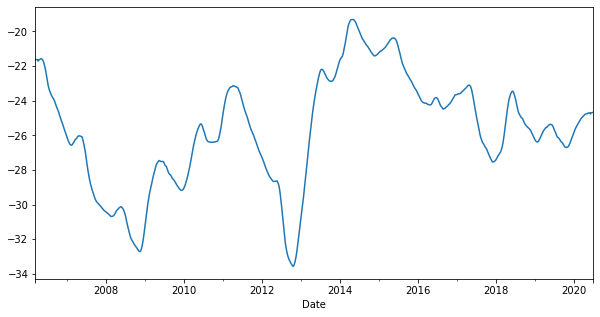

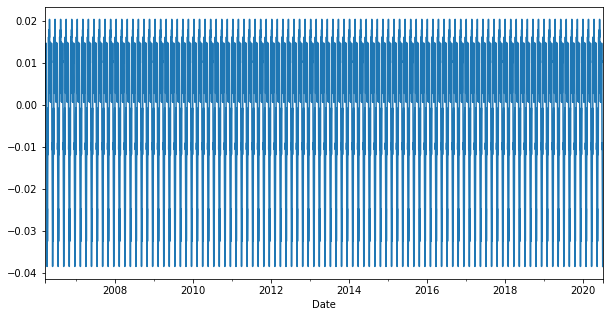

In [536]:
df_model_decomp = plot_decomp(df_model)

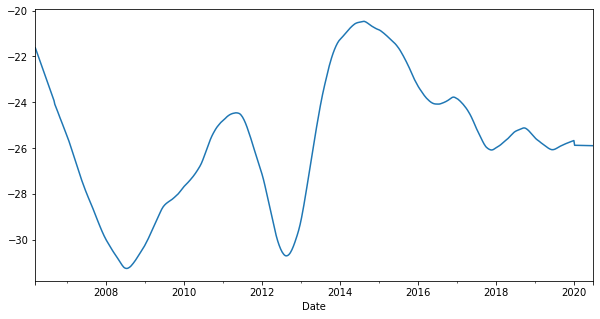

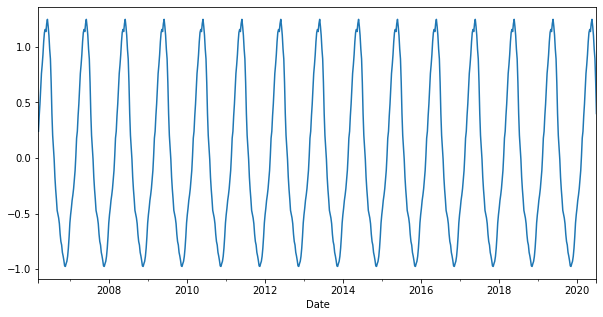

In [537]:
df_model_downsampled_decomp = plot_decomp(df_model_downsampled)

 # Baseline model (ewm)
 
 Exponential Weighted Mean

In [474]:
df_model.head()

,Depth_to_Groundwater
Date,
2006-03-14,-22.18
2006-03-15,-22.14
2006-03-16,-22.04
2006-03-17,-22.04
2006-03-18,-22.04


In [503]:
n_days=365
n_days=30

for n in [1, 2, 3]:
    df_model['Depth_to_Groundwater_fcst_ewm_{}'.format(n)] = df_model["Depth_to_Groundwater"].ewm(span=n_days*n, 
                                                                                                  min_periods=n_days, 
                                                                                                  adjust=True).mean().shift(1)

df_model

,Depth_to_Groundwater,Depth_to_Groundwater_fcst_ewm_1,Depth_to_Groundwater_fcst_ewm_2,Depth_to_Groundwater_fcst_ewm_3
Date,,,,
2006-03-14,-22.18,NaN,NaN,NaN
2006-03-15,-22.14,NaN,NaN,NaN
2006-03-16,-22.04,NaN,NaN,NaN
2006-03-17,-22.04,NaN,NaN,NaN
2006-03-18,-22.04,NaN,NaN,NaN
...,...,...,...,...
2020-06-26,-25.07,-24.779291,-24.775971,-24.828220
2020-06-27,-25.11,-24.798046,-24.785611,-24.833534
2020-06-28,-25.19,-24.818172,-24.796247,-24.839610


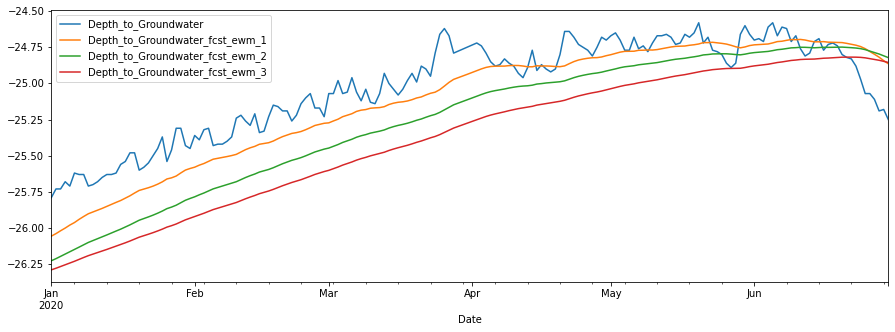

In [506]:
df_model.loc['2020':].plot(figsize=(15,5))

plt.show()

In [505]:
for col in ['Depth_to_Groundwater_fcst_ewm_1', 'Depth_to_Groundwater_fcst_ewm_2', 'Depth_to_Groundwater_fcst_ewm_3']:
    mae = np.mean(np.abs(df_model['Depth_to_Groundwater'] - df_model[col]))
    
    print('MAE {}: {}'.format(col, mae))

MAE Depth_to_Groundwater_fcst_ewm_1: 0.25201924319234387
MAE Depth_to_Groundwater_fcst_ewm_2: 0.4471375875123441
MAE Depth_to_Groundwater_fcst_ewm_3: 0.6074298060301443


# ARIMA

## Check stationarity

Adfuller Test

In [202]:
df_model

,Depth_to_Groundwater,Depth_to_Groundwater_fcst_ewm
Date,,
2006-03-14,-22.18,NaN
2006-03-15,-22.14,NaN
2006-03-16,-22.04,NaN
2006-03-17,-22.04,NaN
2006-03-18,-22.04,NaN
...,...,...
2020-06-26,-25.07,-25.365475
2020-06-27,-25.11,-25.363860
2020-06-28,-25.19,-25.362473


In [203]:
adfuller(df_model['Depth_to_Groundwater'], autolag='AIC')

#Interpretation of results:
#- 0th element is the test statistic: the more negative the more likely to be stationary
#- 1st element is the p-value: if it's small, i.e. < 0.05 then reject null hypothesis (Reject non-stationarity)
#- 4th element (dictionary) is the critical test statistics

(-3.1604976700766123,
 0.022388147805931638,
 28,
 5194,
 {'1%': -3.431609633182582,
  '5%': -2.8620966262332583,
  '10%': -2.5670662920324077},
 -14552.455142994011)

p-value is 0.02 and the Test Statistic is negative (-3.16) --> we could conclude that the time series is stationary, but we will also try to differentiate once

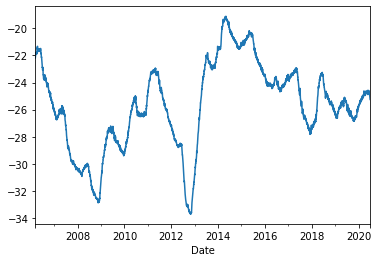

In [204]:
df_model['Depth_to_Groundwater'].plot()

plt.show()

(-6.126333116533689, 8.611293592838759e-08, 27, 5194, {'1%': -3.431609633182582, '5%': -2.8620966262332583, '10%': -2.5670662920324077}, -14542.896429054817)


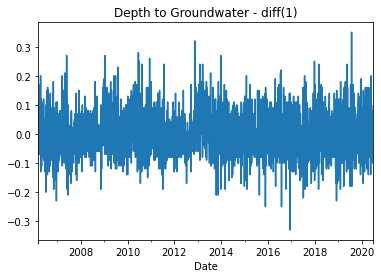

In [205]:
df_model['Depth_to_Groundwater_diff'] = df_model['Depth_to_Groundwater'].diff()

print(adfuller(df_model['Depth_to_Groundwater_diff'].dropna(), autolag='AIC'))

df_model['Depth_to_Groundwater_diff'].plot()
plt.title('Depth to Groundwater - diff(1)')
plt.show()

(-24.727709665934395, 0.0, 26, 5194, {'1%': -3.431609633182582, '5%': -2.8620966262332583, '10%': -2.5670662920324077}, -14505.043922135406)


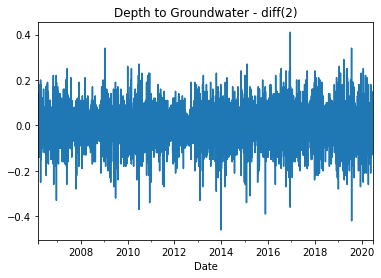

In [252]:
df_model['Depth_to_Groundwater_diff2'] = df_model['Depth_to_Groundwater_diff'].diff()

print(adfuller(df_model['Depth_to_Groundwater_diff2'].dropna(), autolag='AIC'))

df_model['Depth_to_Groundwater_diff2'].plot()
plt.title('Depth to Groundwater - diff(2)')
plt.show()

## Autocorrelation and partial autocorrelation

In [253]:
df_model.head()

,Depth_to_Groundwater,Depth_to_Groundwater_fcst_ewm,Depth_to_Groundwater_diff,Depth_to_Groundwater_diff2
Date,,,,
2006-03-14,-22.18,NaN,NaN,NaN
2006-03-15,-22.14,NaN,0.04,NaN
2006-03-16,-22.04,NaN,0.10,0.06
2006-03-17,-22.04,NaN,0.00,-0.10
2006-03-18,-22.04,NaN,0.00,0.00


In [254]:
df_model.tail()

,Depth_to_Groundwater,Depth_to_Groundwater_fcst_ewm,Depth_to_Groundwater_diff,Depth_to_Groundwater_diff2
Date,,,,
2020-06-26,-25.07,-25.365475,0.00,0.10
2020-06-27,-25.11,-25.363860,-0.04,-0.04
2020-06-28,-25.19,-25.362473,-0.08,-0.04
2020-06-29,-25.18,-25.361530,0.01,0.09
2020-06-30,-25.25,-25.360538,-0.07,-0.08


Depth_to_Groundwater, lags: 50


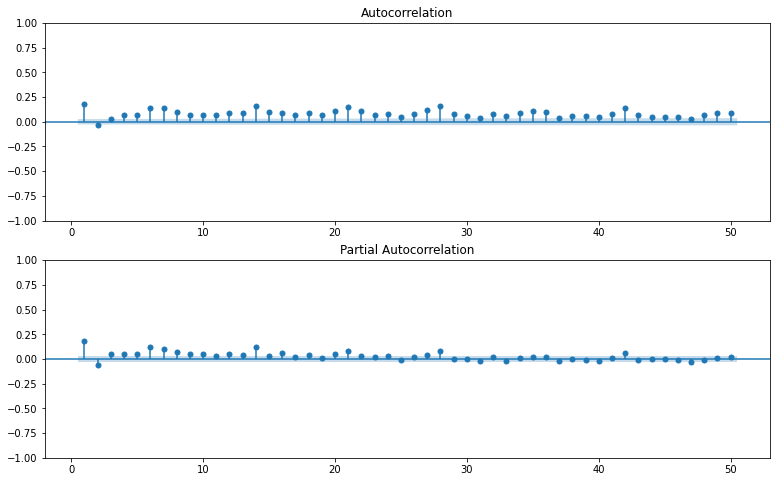

Depth_to_Groundwater_diff, lags: 50


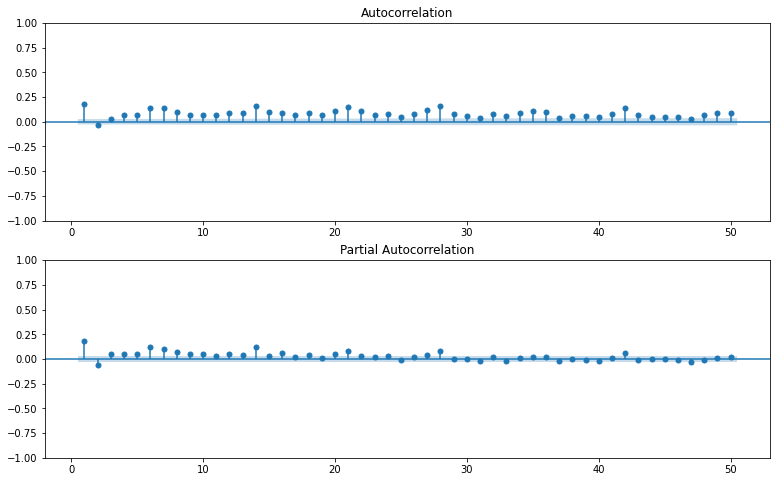

Depth_to_Groundwater_diff2, lags: 50


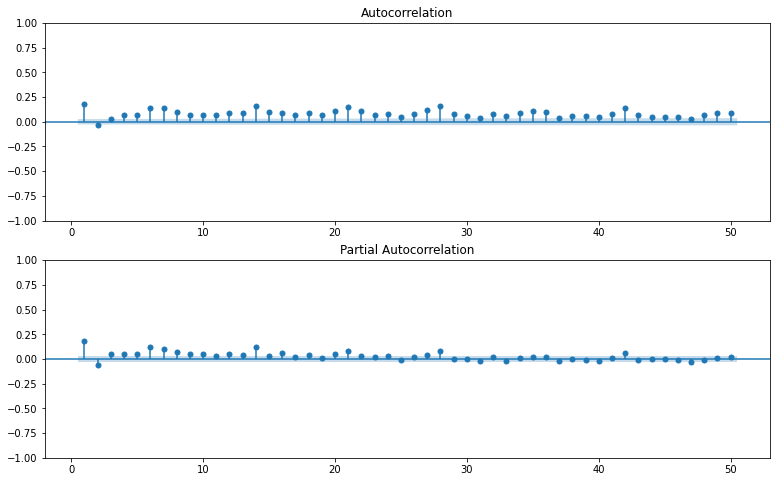

In [257]:
n_lags = 50

for col in ['Depth_to_Groundwater', 'Depth_to_Groundwater_diff', 'Depth_to_Groundwater_diff2']:
    print('{}, lags: {}'.format(col, n_lags))
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 8))

    # Make ACF plot
    plot_acf(df_model[['Depth_to_Groundwater_diff']].dropna(), lags=n_lags, zero=False, ax=ax1)
    
    # Make PACF plot
    plot_pacf(df_model[['Depth_to_Groundwater_diff']].dropna(), lags=n_lags, zero=False, ax=ax2)
    
    plt.show()

## Choosing a model

We will use AIC and BIC to choose the best model

- AIC: The lower the value for AIC, the better the fit of the model. The absolute value of the AIC value is not important. It can be positive or negative
- BIC: The lower the better

In [64]:
# Our data is stationary so we will be using ARIMA and not exponential methods 
# AR (autoregressive) + I (integrated) + MA (moving average)
# p = order of the autoregression (according to lags)
# d = order of differenciating
# q = order of moving average
# you choose the parameters based on how many lags you want to get as in sequence 
# AR and MA do not necessarily get used together, sometimes just one of them and so p or q becomes 0

In [317]:
order_aic_bic =[]

# Loop over I order (differentiation)
for i in range(3):
    # Loop over AR order
    for p in range(3):
    # Loop over MA order
        for q in range(3):
            # Fit model
            model = SARIMAX(df_model[["Depth_to_Groundwater"]], order=(p,i,q))
            results = model.fit()
            # Add order and scores to list
            order_aic_bic.append((p, i, q, results.aic, results.bic))

In [320]:
# Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order_aic_bic, columns=['p', 'i', 'q', 'aic', 'bic'])

# Sort by AIC
order_df.sort_values('aic')

,p,i,q,aic,bic
26,2,2,2,-14506.939585,-14474.137364
25,2,2,1,-14496.483008,-14470.241231
23,1,2,2,-14434.341687,-14408.099910
20,0,2,2,-14403.965457,-14384.284125
22,1,2,1,-14386.082333,-14366.401000
19,0,2,1,-14339.823850,-14326.702962
8,2,0,2,-14227.453036,-14194.648900
11,0,1,2,-14215.408900,-14195.726993
13,1,1,1,-14215.317266,-14195.635358
16,2,1,1,-14213.665516,-14187.422973


In [321]:
# Sort by AIC
order_df.sort_values('bic')

,p,i,q,aic,bic
26,2,2,2,-14506.939585,-14474.137364
25,2,2,1,-14496.483008,-14470.241231
23,1,2,2,-14434.341687,-14408.099910
20,0,2,2,-14403.965457,-14384.284125
22,1,2,1,-14386.082333,-14366.401000
19,0,2,1,-14339.823850,-14326.702962
10,0,1,1,-14212.021697,-14198.900425
11,0,1,2,-14215.408900,-14195.726993
13,1,1,1,-14215.317266,-14195.635358
8,2,0,2,-14227.453036,-14194.648900


We choose order (2, 2, 2) as it is the one with both lower AIC and lower BIC

## Analyze the Residuals

If the model fits well, the residuals will be white Gaussian noise

In [307]:
model = ARIMA(df_model["Depth_to_Groundwater"].dropna(), order=(2,2,2)) 
res_222 = model.fit()
print(res_222.summary())

                                SARIMAX Results                                 
Dep. Variable:     Depth_to_Groundwater   No. Observations:                 5223
Model:                   ARIMA(2, 2, 2)   Log Likelihood                7258.470
Date:                  Sun, 19 Jun 2022   AIC                         -14506.940
Time:                          17:32:17   BIC                         -14474.137
Sample:                      03-14-2006   HQIC                        -14495.468
                           - 06-30-2020                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6092      0.056     10.871      0.000       0.499       0.719
ar.L2         -0.2010      0.013    -15.642      0.000      -0.226      -0.176
ma.L1         -1.4788      0.056    

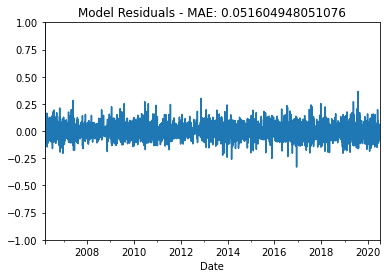

In [308]:
residuals = res_222.resid
mae = np.mean(np.abs(residuals))

residuals.plot()
plt.ylim((-1, 1))
plt.title('Model Residuals - MAE: {}'.format(mae))
plt.show()

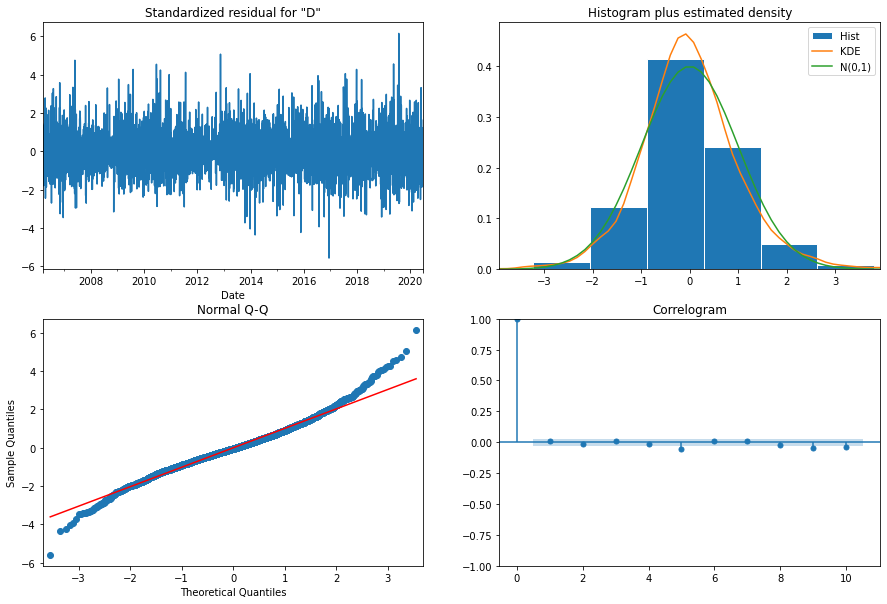

In [309]:
res_222.plot_diagnostics(figsize=(15, 10))
plt.show()

In [311]:
print(res_222.summary())

# Interpret Results
# - Prob(Q): p-value for null hypothesis that residuals are uncorrelated
# - Prob(JB): p-value for null hypothesis that residuals are normal

                                SARIMAX Results                                 
Dep. Variable:     Depth_to_Groundwater   No. Observations:                 5223
Model:                   ARIMA(2, 2, 2)   Log Likelihood                7258.470
Date:                  Sun, 19 Jun 2022   AIC                         -14506.940
Time:                          17:34:29   BIC                         -14474.137
Sample:                      03-14-2006   HQIC                        -14495.468
                           - 06-30-2020                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6092      0.056     10.871      0.000       0.499       0.719
ar.L2         -0.2010      0.013    -15.642      0.000      -0.226      -0.176
ma.L1         -1.4788      0.056    

## Auto ARIMA

In [326]:
results_auto = pm.auto_arima(df_model['Depth_to_Groundwater'])

In [327]:
print(results_auto.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5223
Model:               SARIMAX(1, 1, 4)   Log Likelihood                7281.039
Date:                Sun, 19 Jun 2022   AIC                         -14550.079
Time:                        17:42:19   BIC                         -14510.715
Sample:                             0   HQIC                        -14536.313
                               - 5223                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9883      0.003    307.212      0.000       0.982       0.995
ma.L1         -0.8604      0.012    -70.058      0.000      -0.884      -0.836
ma.L2         -0.2392      0.017    -14.153      0.0

## Make Forecast

In [355]:
# Make in-sample prediction (for last 30 days)
forecast = res_222.get_prediction(start=-30)

# forecast mean
mean_forecast = forecast.predicted_mean

# get confidence intervals for forecast
confidence_intervals = forecast.conf_int()

In [356]:
mean_forecast.head()

Date
2020-06-01   -24.687235
2020-06-02   -24.704028
2020-06-03   -24.680900
2020-06-04   -24.708044
2020-06-05   -24.590891
Freq: D, Name: predicted_mean, dtype: float64

In [357]:
confidence_intervals.head()

,lower Depth_to_Groundwater,upper Depth_to_Groundwater
Date,,
2020-06-01,-24.803616,-24.570855
2020-06-02,-24.820408,-24.587648
2020-06-03,-24.797280,-24.564520
2020-06-04,-24.824424,-24.591664
2020-06-05,-24.707271,-24.474511


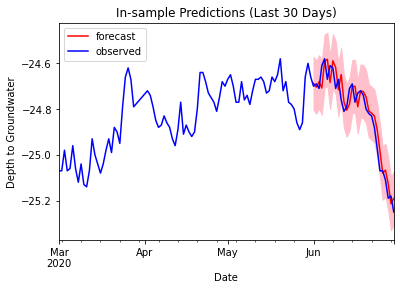

In [359]:
# Plot in-sample prediction (last 30 days)

fig, ax = plt.subplots(1, 1)
pd.DataFrame(mean_forecast).plot(color='r', label='forecast', ax=ax)
df_model[['Depth_to_Groundwater']].loc['2020-03':].plot(color='b', label='observed', ax=ax)

plt.fill_between(confidence_intervals.index, 
                 confidence_intervals['lower Depth_to_Groundwater'], 
                 confidence_intervals['upper Depth_to_Groundwater'], 
                 color='pink')
plt.legend(['forecast', 'observed'])
plt.ylabel('Depth to Groundwater')
plt.title('In-sample Predictions (Last 30 Days)')

plt.show()

In [353]:
# Making In-Sample Dynamic Predictions (for last 30 days)
forecast_dynamic = res_222.get_prediction(start=-30, dynamic=True)

# forecast mean
mean_forecast_dynamic = forecast_dynamic.predicted_mean

# get confidence intervals for forecast
confidence_intervals_dynamic = forecast_dynamic.conf_int()

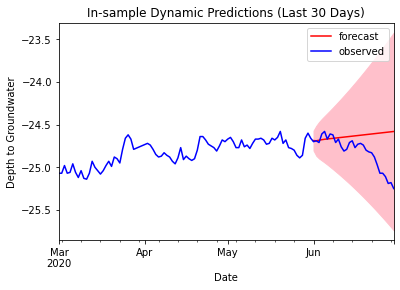

In [360]:
# Plot in-sample Dynamic Predictions (last 30 days)

fig, ax = plt.subplots(1, 1)
pd.DataFrame(mean_forecast_dynamic).plot(color='r', label='forecast', ax=ax)
df_model[['Depth_to_Groundwater']].loc['2020-03':].plot(color='b', label='observed', ax=ax)

plt.fill_between(confidence_intervals_dynamic.index, 
                 confidence_intervals_dynamic['lower Depth_to_Groundwater'], 
                 confidence_intervals_dynamic['upper Depth_to_Groundwater'], 
                 color='pink')
plt.legend(['forecast', 'observed'])
plt.ylabel('Depth to Groundwater')
plt.title('In-sample Dynamic Predictions (Last 30 Days)')

plt.show()

In [366]:
# Forecasting Out of  Sample (Next 30 days)

forecast_os = res_222.get_forecast(steps=30)

mean_forecast_os = forecast_os.predicted_mean

confidence_intervals_oc = forecast_os.conf_int()

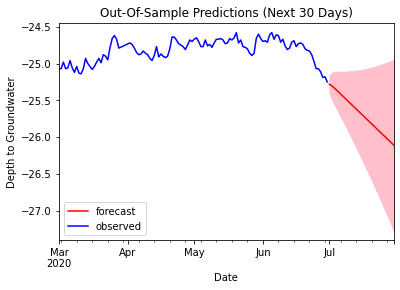

In [369]:
# Plot Out-of-Sample Predictions (last 30 days)

fig, ax = plt.subplots(1, 1)
pd.DataFrame(mean_forecast_os).plot(color='r', label='forecast', ax=ax)
df_model[['Depth_to_Groundwater']].loc['2020-03':].plot(color='b', label='observed', ax=ax)

plt.fill_between(confidence_intervals_oc.index, 
                 confidence_intervals_oc['lower Depth_to_Groundwater'], 
                 confidence_intervals_oc['upper Depth_to_Groundwater'], 
                 color='pink')
plt.legend(['forecast', 'observed'])
plt.ylabel('Depth to Groundwater')
plt.title('Out-Of-Sample Predictions (Next 30 Days)')

plt.show()

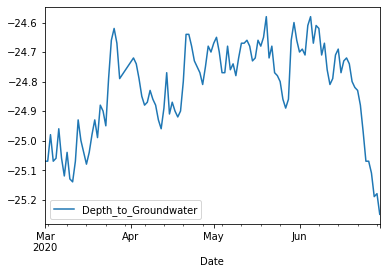

In [373]:
df_model[['Depth_to_Groundwater']].loc['2020-03':].plot()

plt.show()

# Train-Test Split

In [374]:
df_model.head()

,Depth_to_Groundwater,Depth_to_Groundwater_fcst_ewm,Depth_to_Groundwater_diff,Depth_to_Groundwater_diff2
Date,,,,
2006-03-14,-22.18,NaN,NaN,NaN
2006-03-15,-22.14,NaN,0.04,NaN
2006-03-16,-22.04,NaN,0.10,0.06
2006-03-17,-22.04,NaN,0.00,-0.10
2006-03-18,-22.04,NaN,0.00,0.00


In [395]:
end_train = '2019'
start_test = '2020'

df_train = df_model.loc[:'2019']
df_test = df_model.loc['2020':]

In [396]:
df_test.head()

,Depth_to_Groundwater,Depth_to_Groundwater_fcst_ewm,Depth_to_Groundwater_diff,Depth_to_Groundwater_diff2
Date,,,,
2020-01-01,-25.79,-26.065677,0.08,0.08
2020-01-02,-25.73,-26.064171,0.06,-0.02
2020-01-03,-25.73,-26.062345,0.00,-0.06
2020-01-04,-25.68,-26.060529,0.05,0.05
2020-01-05,-25.71,-26.058449,-0.03,-0.08


In [403]:
df_train.tail()

,Depth_to_Groundwater,Depth_to_Groundwater_fcst_ewm,Depth_to_Groundwater_diff,Depth_to_Groundwater_diff2
Date,,,,
2019-12-27,-25.85,-26.071389,-0.10,-0.17
2019-12-28,-25.89,-26.070180,-0.04,0.06
2019-12-29,-25.82,-26.069195,0.07,0.11
2019-12-30,-25.87,-26.067833,-0.05,-0.12
2019-12-31,-25.87,-26.066752,0.00,0.05


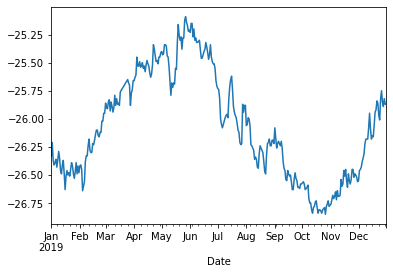

In [412]:
df_train['Depth_to_Groundwater'].loc['2019':].plot()

plt.show()

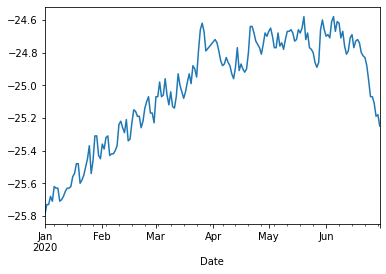

In [410]:
df_test['Depth_to_Groundwater'].plot()

plt.show()

In [413]:
model = ARIMA(df_train["Depth_to_Groundwater"].dropna(), order=(2,2,2)) 
res_222_train = model.fit()
print(res_222_train.summary())

                                SARIMAX Results                                 
Dep. Variable:     Depth_to_Groundwater   No. Observations:                 5041
Model:                   ARIMA(2, 2, 2)   Log Likelihood                7030.320
Date:                  Sun, 19 Jun 2022   AIC                         -14050.640
Time:                          18:34:34   BIC                         -14018.015
Sample:                      03-14-2006   HQIC                        -14039.210
                           - 12-31-2019                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6038      0.064      9.427      0.000       0.478       0.729
ar.L2         -0.1978      0.013    -14.859      0.000      -0.224      -0.172
ma.L1         -1.4645      0.065    

In [442]:
# Forecasting Out of  Sample (Next 30 days)

forecast_test = res_222_train.get_forecast(steps=df_test.shape[0], dynamic=True)

df_test['mean_forecast'] = forecast_test.predicted_mean

confidence_intervals_test = forecast_test.conf_int()

df_test['lower_forecast'] = confidence_intervals_test.iloc[:,0]
df_test['upper_forecast'] = confidence_intervals_test.iloc[:,1]

In [445]:
df_test.head()

,Depth_to_Groundwater,Depth_to_Groundwater_fcst_ewm,Depth_to_Groundwater_diff,Depth_to_Groundwater_diff2,mean_forecast,lower_forecast,upper_forecast
Date,,,,,,,
2020-01-01,-25.79,-26.065677,0.08,0.08,-25.847924,-25.965399,-25.730449
2020-01-02,-25.73,-26.064171,0.06,-0.02,-25.826115,-26.004192,-25.648038
2020-01-03,-25.73,-26.062345,0.00,-0.06,-25.808834,-26.025681,-25.591987
2020-01-04,-25.68,-26.060529,0.05,0.05,-25.794233,-26.040953,-25.547514
2020-01-05,-25.71,-26.058449,-0.03,-0.08,-25.780356,-26.054397,-25.506314


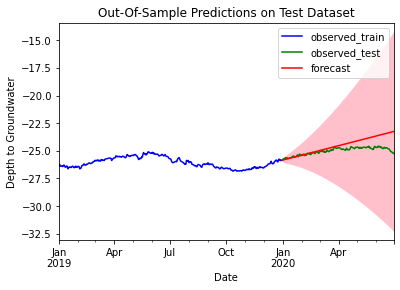

In [446]:
fig, ax = plt.subplots(1, 1)
df_train['Depth_to_Groundwater'].loc['2019':].plot(color='b', label='observed_train', ax=ax)
df_test[['Depth_to_Groundwater', 'mean_forecast']].plot(color=['g', 'r'], label=['observed_test', 'forecast'], ax=ax)

plt.fill_between(df_test.index, 
                 df_test['lower_forecast'], 
                 df_test['upper_forecast'], 
                 color='pink')
plt.legend(['observed_train', 'observed_test', 'forecast'])
plt.ylabel('Depth to Groundwater')
plt.title('Out-Of-Sample Predictions on Test Dataset')

plt.show()

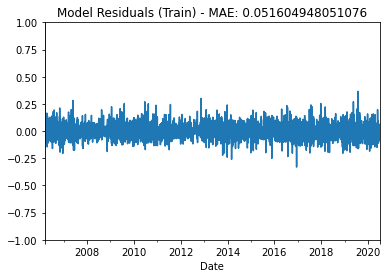

In [447]:
residuals_train = res_222_train.resid
mae_train = np.mean(np.abs(residuals_train))

residuals.plot()
plt.ylim((-1, 1))
plt.title('Model Residuals (Train) - MAE: {}'.format(mae))
plt.show()

In [512]:
score_mae = mean_absolute_error(df_test['Depth_to_Groundwater'], df_test['mean_forecast'])
score_rmse = math.sqrt(mean_squared_error(df_test['Depth_to_Groundwater'], df_test['mean_forecast']))

print('MAE: {}'.format(score_mae))
print('RMSE: {}'.format(score_rmse))

MAE: 0.4947890077839763
RMSE: 0.6961542939907955
